In [18]:
import cv2
import supervision as sv
import numpy as np

In [19]:
from PIL import Image

def draw_grounding_dino_box(image_path_or_array, gd_output_dict):
    """
    Draws bounding boxes and labels from Grounding DINO output onto an image.

    Args:
        image_path_or_array (str or np.ndarray): Path to the input image or an image loaded as a NumPy array.
        gd_output_dict (dict): The Grounding DINO output dictionary.
                                Example: {'text': {'boxes': [[0.07, 0.23, 0.95, 0.71]],
                                                    'logits': [0.87],
                                                    'phrases': ['car'],
                                                    'size': [533, 800]}, 'error_code': 0}

    Returns:
        np.ndarray: The image with bounding boxes drawn.
    """
    # 1. 加载图像
    if isinstance(image_path_or_array, str):
        image = cv2.imread(image_path_or_array)
        if image is None:
            raise FileNotFoundError(f"Image not found at {image_path_or_array}")
    elif isinstance(image_path_or_array, np.ndarray):
        image = image_path_or_array.copy()
    else:
        raise TypeError("image_path_or_array must be a string path or a numpy array.")

    # 2. 从 Grounding DINO 输出中提取数据
    text_data = gd_output_dict.get('text')
    if not text_data or not text_data.get('boxes'):
        print("Warning: No detections found in Grounding DINO output. Returning original image.")
        return image

    boxes_normalized = np.array(text_data['boxes'])
    logits = np.array(text_data['logits'])
    phrases = text_data['phrases']
    
    current_image_height, current_image_width = image.shape[:2]

    # 3. 将归一化的坐标转换为像素坐标
    boxes_pixel = boxes_normalized * np.array([current_image_width, current_image_height, current_image_width, current_image_height])
    boxes_pixel = boxes_pixel.astype(int)

    # 4. 为 supervision 的 Detections 对象准备数据
    # 即使使用单一颜色，Detections 对象仍然需要 class_id
    # 因为 BoxAnnotator 和 LabelAnnotator 仍然依赖 class_id 来匹配 class_names (如果提供的话)
    # 如果你不想 class_id 影响颜色，直接传入 sv.Color.RED 这样的固定颜色即可
    unique_phrases = sorted(list(set(phrases)))
    phrase_to_class_id = {phrase: i for i, phrase in enumerate(unique_phrases)}
    class_ids = np.array([phrase_to_class_id[p] for p in phrases])

    detections = sv.Detections(
        xyxy=boxes_pixel,
        confidence=logits,
        class_id=class_ids
    )

    # 5. 初始化 BoxAnnotator (只负责框)
    # <--- 关键修改：直接指定一个颜色，比如 sv.Color.RED
    box_annotator = sv.BoxAnnotator(
        thickness=2,          # 边界框线条粗细
        color=sv.Color.RED    # 所有框都显示为红色
    )

    # 6. 初始化 LabelAnnotator (负责文本标签)
    # <--- 关键修改：直接指定一个颜色，比如 sv.Color.RED
    label_annotator = sv.LabelAnnotator(
        text_thickness=1,     # 文本线条粗细
        text_padding=4,       # 文本填充
        text_scale=0.7,       # 文本大小
        color=sv.Color.RED    # 所有标签背景和文字都显示为红色
    )

    # 7. 准备自定义标签文本
    labels = [
        f"{phrase} {confidence:.2f}"
        for phrase, confidence in zip(phrases, logits)
    ]

    # 8. 先绘制边界框
    annotated_image = box_annotator.annotate(
        scene=image.copy(),
        detections=detections
    )

    # 9. 再绘制标签文本 (在已经有框的图片上)
    annotated_image = label_annotator.annotate(
        scene=annotated_image,
        detections=detections,
        labels=labels,
    )
    
    # 10. Convert OpenCV image (BGR) to PIL Image (RGB)
    annotated_image_bgr = annotated_image.copy()
    annotated_image_rgb = cv2.cvtColor(annotated_image_bgr, cv2.COLOR_BGR2RGB)
    annotated_image_pil = Image.fromarray(annotated_image_rgb)

    return annotated_image_pil

In [20]:
image = "/mnt/petrelfs/songmingyang/code/reasoning/tool-agent/tool_server/tool_workers/online_workers/test_cases/truck.jpg"
gd_output = {'text': {'boxes': [[0.07, 0.23, 0.95, 0.71]], 'logits': [0.87], 'phrases': ['car'], 'size': [533, 800]}, 'error_code': 0}
annotated_image = draw_grounding_dino_box(image, gd_output)

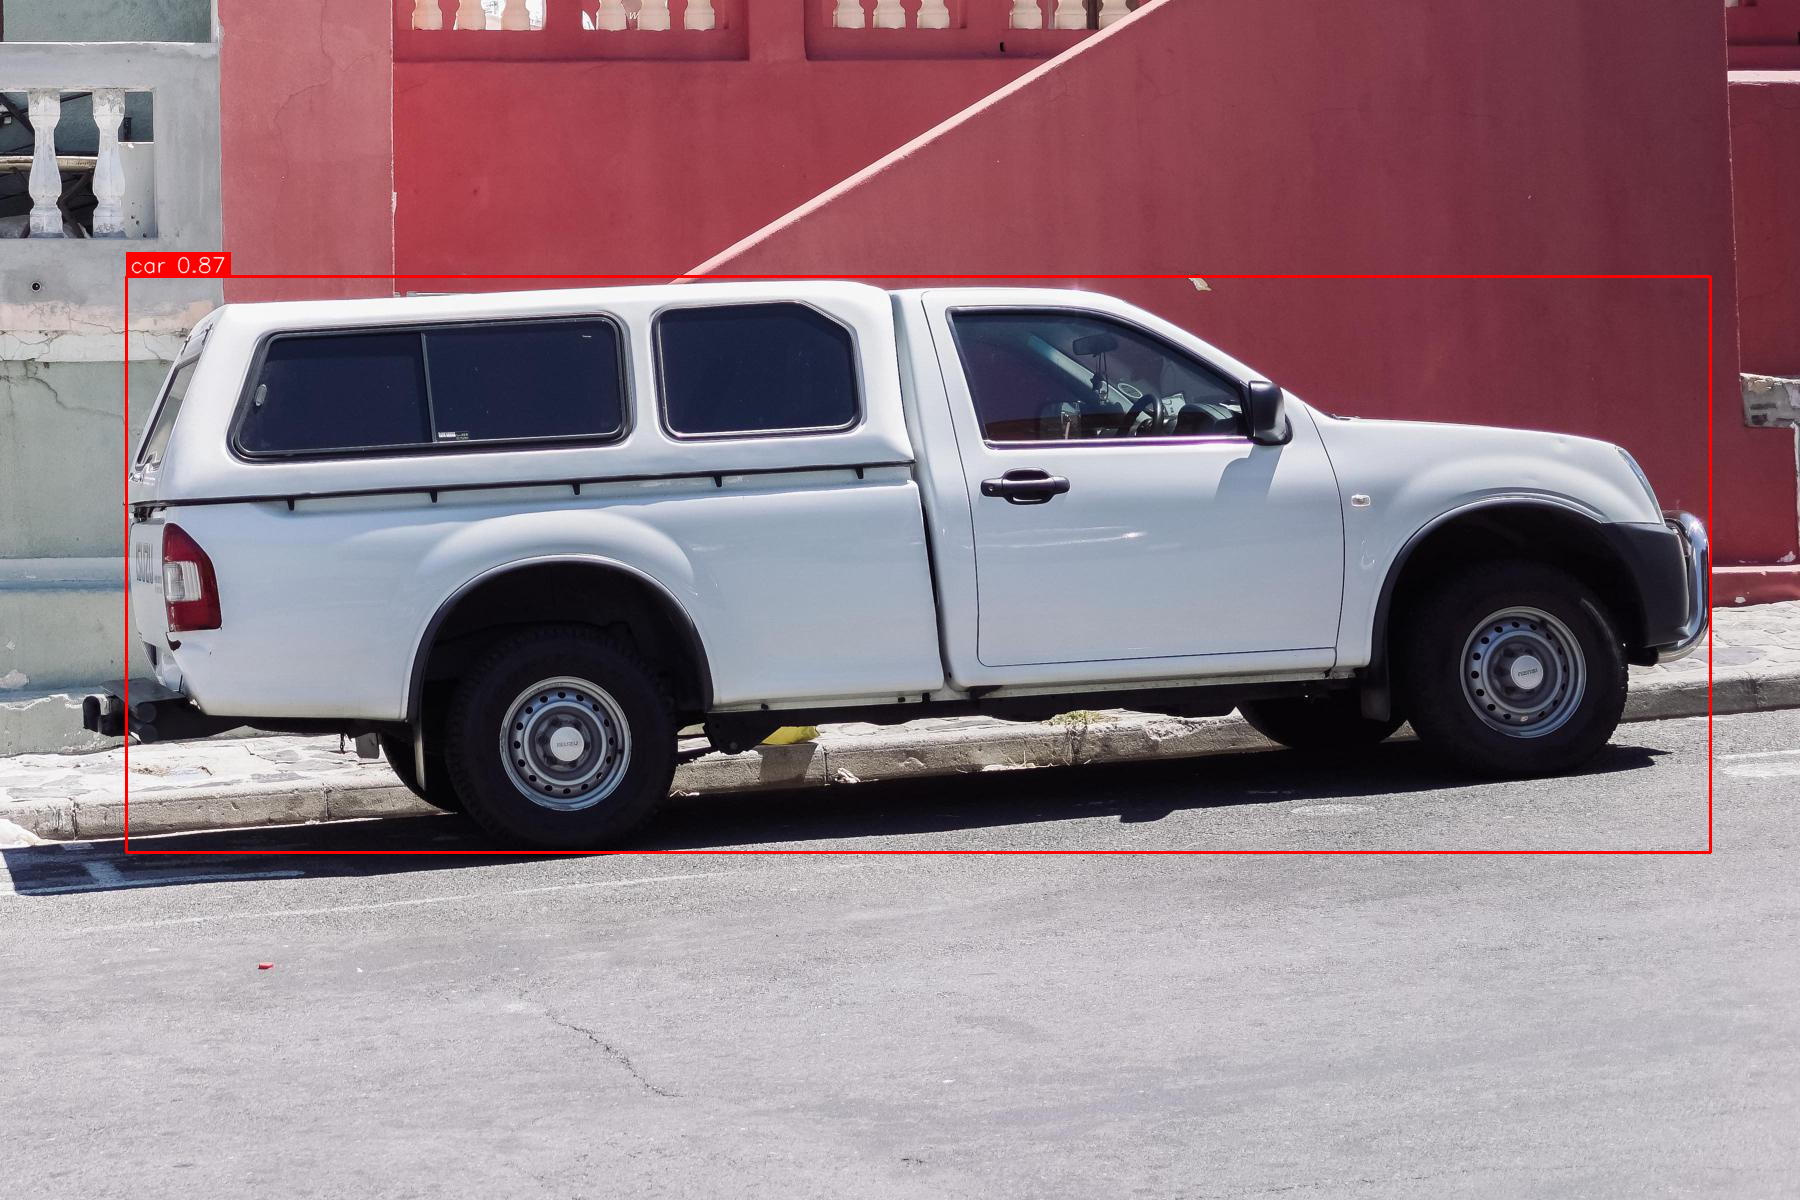

In [17]:
annotated_image